In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\hmche\AppData\Local\Temp\ipykernel_11424\3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Combined(training) -> 2021 data (testing)

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2021 train -> 2017 test

In [5]:
df = pd.read_csv('SRER21_dataset_v1.csv', na_values='?').dropna()
df2 = pd.read_csv('SRER_2017_training_bi.csv', na_values='?').dropna()
df3 = pd.concat(([df,df2]),ignore_index=True)
df3.isnull().sum()
df3.dropna(axis=0,inplace=True)
df3

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,2,2,2,20.4,2.38,1.000000,0.273945,0.273945,0.273945,0.323257,0.323257,0.323257,0.428208,0.428208,0.428208,0.311936,0.311936,0.311936,woody
1,3,3,3,8.2,1.32,1.000000,0.530157,0.530157,0.530157,0.460513,0.460513,0.460513,0.611745,0.611745,0.611745,0.416492,0.416492,0.416492,woody
2,4,4,4,55.8,24.43,0.920000,0.477979,0.501013,0.616707,0.381095,0.384718,0.447304,0.576437,0.596638,0.673767,0.359786,0.364317,0.414173,woody
3,5,5,5,15.2,1.88,1.000000,0.342944,0.342944,0.342944,0.346714,0.346714,0.346714,0.468738,0.468738,0.468738,0.323907,0.323907,0.323907,woody
4,6,6,6,27.2,9.29,0.142857,0.044382,-0.008903,0.265536,0.181714,0.147391,0.315684,0.223522,0.178629,0.412030,0.177739,0.147325,0.299311,non-woody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,4335,4487,4487,8.8,2.30,0.020000,0.290182,0.290182,0.290182,0.283959,0.283959,0.283959,0.419200,0.419200,0.419200,0.269486,0.269486,0.269486,woody
11140,4336,4488,4488,10.8,2.03,0.020000,0.408320,0.408320,0.408320,0.372648,0.372648,0.372648,0.510469,0.510469,0.510469,0.340879,0.340879,0.340879,woody
11141,4337,4489,4489,11.8,2.62,0.015000,0.413297,0.413297,0.437195,0.234926,0.234926,0.235606,0.485601,0.485601,0.499074,0.226722,0.226722,0.227606,woody
11142,4338,4490,4490,11.2,3.09,0.015000,0.550652,0.550652,0.570094,0.388085,0.388085,0.416298,0.621694,0.621694,0.640722,0.363288,0.363288,0.387576,woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []
    
X_train = df3.iloc[:, 5:18]
X_test = df.iloc[:, 5:18]
Y_train = df3.iloc[:, -1]
Y_test = df.iloc[:, -1]

model.fit(X_train, Y_train)
pred_values = model.predict(X_test)

acc = accuracy_score(Y_test, pred_values)
acc_score.append(acc)

Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.13297480000000128 seconds ---

Accuracy of each fold: 
 [0.8637766348273328]
Avg accuracy: 0.8637766348273328
Std of accuracy : 
0.0

[[1701  529]
 [ 398 4177]]

              precision    recall  f1-score   support

   non-woody       0.81      0.76      0.79      2230
       woody       0.89      0.91      0.90      4575

    accuracy                           0.86      6805
   macro avg       0.85      0.84      0.84      6805
weighted avg       0.86      0.86      0.86      6805

0.762780269058296
0.9130054644808743
0.8103858980466889
0.7858627858627858


In [7]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []
  
X_train = df3.iloc[:, 5:18]
X_test = df.iloc[:, 5:18]
Y_train = df3.iloc[:, -1]
Y_test = df.iloc[:, -1]


model.fit(X_train, Y_train)
pred_values = model.predict(X_test)
    
acc = accuracy_score(Y_test, pred_values)
acc_score.append(acc)

Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 0.6801351000000011 seconds ---

Accuracy of each fold: 
 [0.8578986039676708]
Avg accuracy: 0.8578986039676708
Std of accuracy : 
0.0

[[1705  525]
 [ 442 4133]]

              precision    recall  f1-score   support

   non-woody       0.79      0.76      0.78      2230
       woody       0.89      0.90      0.90      4575

    accuracy                           0.86      6805
   macro avg       0.84      0.83      0.84      6805
weighted avg       0.86      0.86      0.86      6805

0.7645739910313901
0.9033879781420765
0.7941313460642757
0.779072424034727


In [8]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

X_train = df3.iloc[:, 5:18]
X_test = df.iloc[:, 5:18]
Y_train = df3.iloc[:, -1]
Y_test = df.iloc[:, -1]


model.fit(X_train, Y_train)
pred_values = model.predict(X_test)
    

acc = accuracy_score(Y_test, pred_values)
acc_score.append(acc)

Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 1.1654012000000016 seconds ---

Accuracy of each fold: 
 [0.8355620867009552]
Avg accuracy: 0.8355620867009552
Std of accuracy : 
0.0

[[1793  437]
 [ 682 3893]]

              precision    recall  f1-score   support

   non-woody       0.72      0.80      0.76      2230
       woody       0.90      0.85      0.87      4575

    accuracy                           0.84      6805
   macro avg       0.81      0.83      0.82      6805
weighted avg       0.84      0.84      0.84      6805

0.8040358744394619
0.8509289617486339
0.7244444444444444
0.7621679064824655


#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [9]:
KNN_result = []
X=df3.iloc[:, 5:18]
Y=df3.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.72005384 0.74383131 0.72768057 0.72857784 0.744614  ]

Avg accuracy: 0.7329515131452302

K=2

Accuracy of each fold: 
 [0.73126963 0.72992373 0.73037236 0.72633468 0.72621185]

Avg accuracy: 0.7288224505921214

K=3

Accuracy of each fold: 
 [0.7577389  0.74831763 0.75100942 0.74876626 0.74820467]

Avg accuracy: 0.750807375923541

K=4

Accuracy of each fold: 
 [0.75414984 0.75056079 0.747869   0.75190668 0.74685817]

Avg accuracy: 0.7502688970990364

K=5

Accuracy of each fold: 
 [0.7577389  0.77209511 0.75729026 0.76087932 0.75359066]

Avg accuracy: 0.7603188506652556

K=6

Accuracy of each fold: 
 [0.76401974 0.77299237 0.76895469 0.76581427 0.75763016]

Avg accuracy: 0.765882245864655

K=7

Accuracy of each fold: 
 [0.76805742 0.77747869 0.77299237 0.77209511 0.76436266]

Avg accuracy: 0.7709972510235165

K=8

Accuracy of each fold: 
 [0.76536563 0.77613279 0.77972185 0.77433827 0.76122083]

Avg accuracy: 0.7713558744572322

K=9

Accuracy of each fold

In [10]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=8)

acc_score = []
Truth = []
Output = []

X_train = df3.iloc[:, 5:18]
X_test = df.iloc[:, 5:18]
Y_train = df3.iloc[:, -1]
Y_test = df.iloc[:, -1]

model.fit(X_train, Y_train)
pred_values = model.predict(X_test)

acc = accuracy_score(Y_test, pred_values)
acc_score.append(acc)

Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 18.6323572 seconds ---

Accuracy of each fold: 
 [0.8752387950036737]
Avg accuracy: 0.8752387950036737
Std of accuracy : 
0.0

[[1890  340]
 [ 509 4066]]

              precision    recall  f1-score   support

   non-woody       0.79      0.85      0.82      2230
       woody       0.92      0.89      0.91      4575

    accuracy                           0.88      6805
   macro avg       0.86      0.87      0.86      6805
weighted avg       0.88      0.88      0.88      6805

0.8475336322869955
0.8887431693989071
0.78782826177574
0.8165910563836682


In [11]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.863777,0.0,0.762780,0.913005,0.810386,0.785863,0.132975
LDA,0.857899,0.0,0.764574,0.903388,0.794131,0.779072,0.680135
QDA,0.835562,0.0,0.804036,0.850929,0.724444,0.762168,1.165401
KNN-CV,0.875239,0.0,0.847534,0.888743,0.787828,0.816591,18.632357


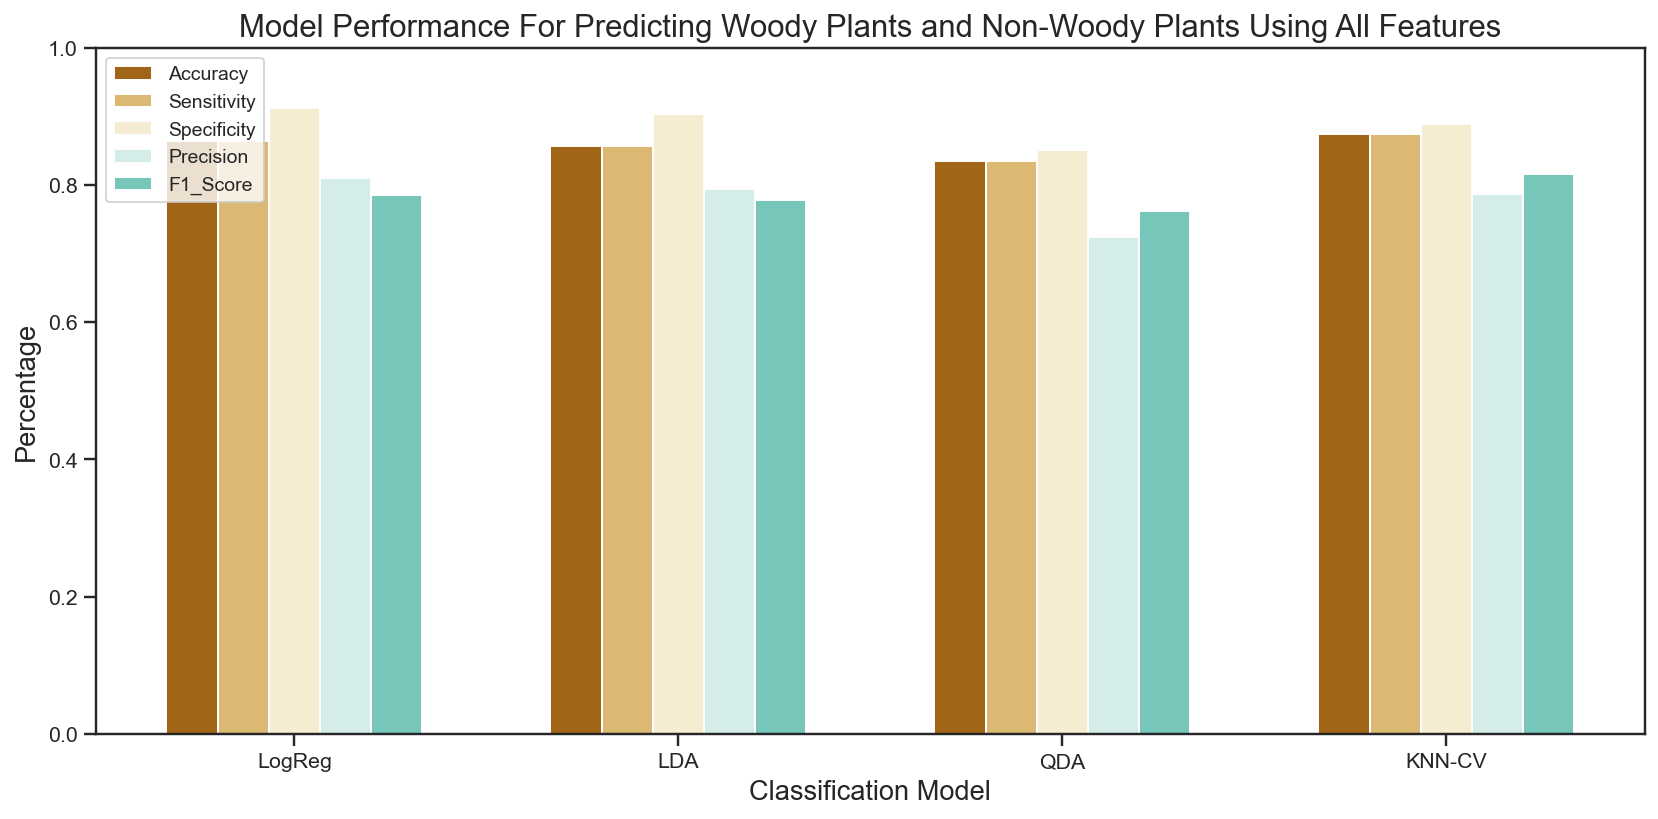

In [17]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statallfeatures_dic["Accuracy"]
sensitivities = statallfeatures_dic["Accuracy"]
specificities = statallfeatures_dic["Specificity"]
precisions = statallfeatures_dic["Precision"]
f1_scores = statallfeatures_dic["F1_Score"]

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody Plants and Non-Woody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

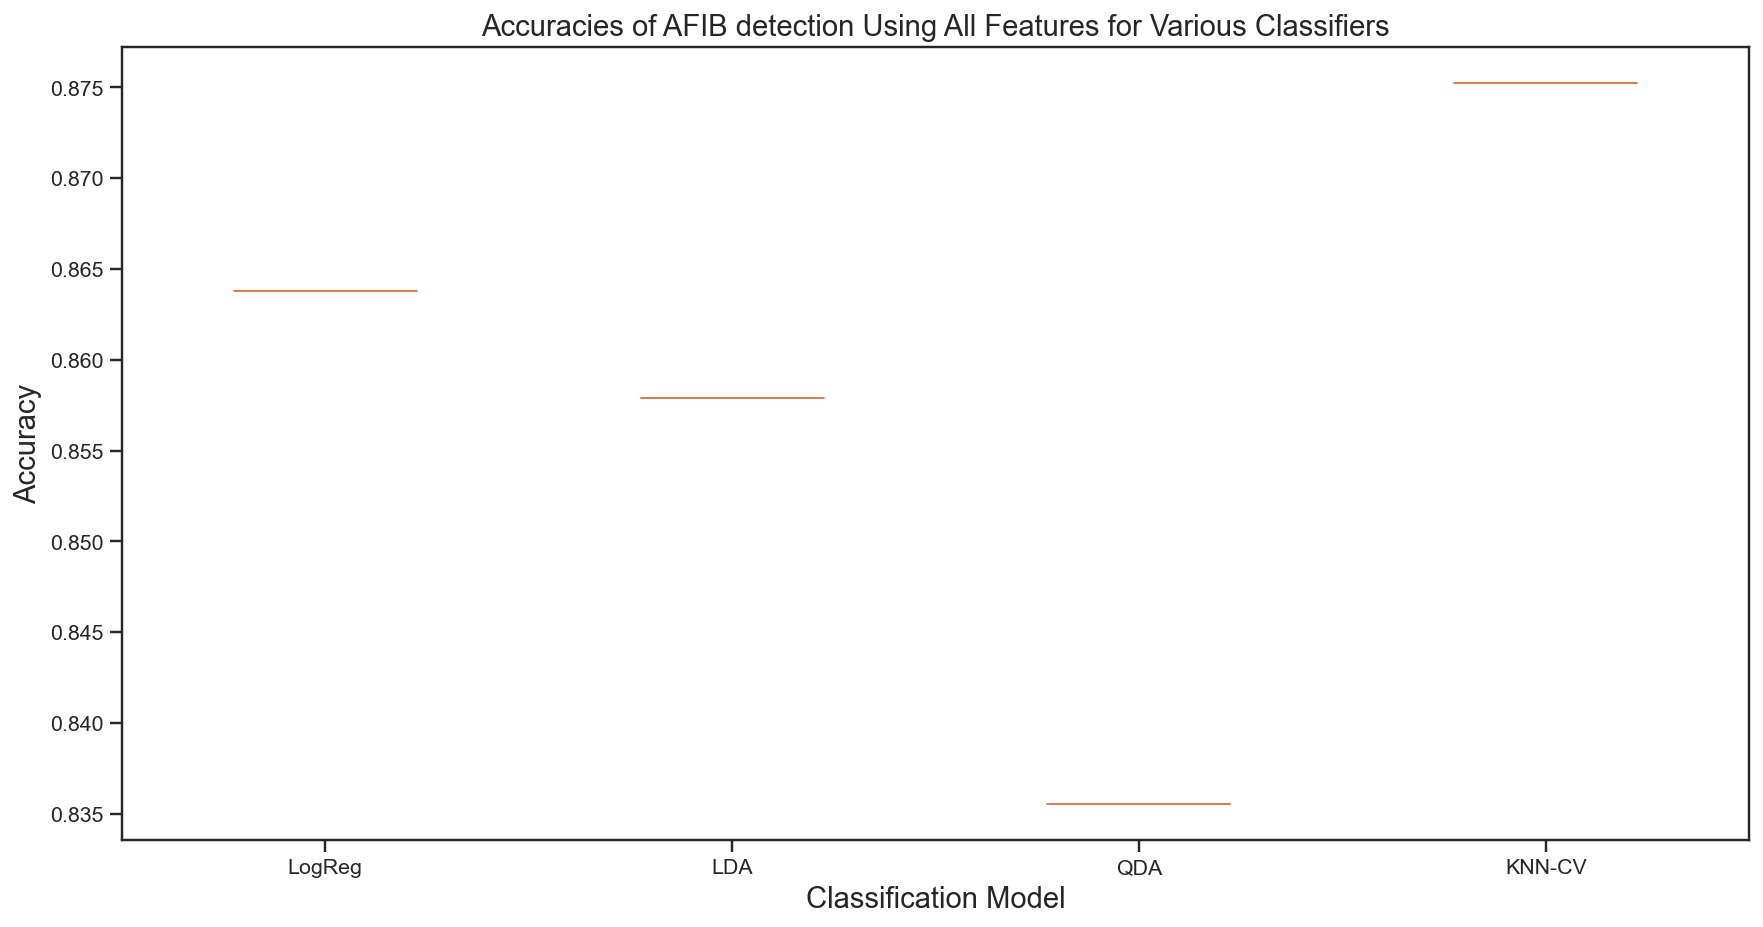

In [16]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()